# MEDCNN $\mathcal{G}_{\phi, \psi}$ 2D

```python
""" MEDCNN 2D training pipeline (Google colab tutorial)
    
    MEDCNN: Multiresolution Encoder-Decoder Convolutional Neural Network
    Copyright (C) 2025 Kishore Kumar Tarafdar
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""
```



In [1]:
pwd

'/content'

In [2]:
!python --version

Python 3.11.11


In [3]:
# !sudo apt-get update -y
# !sudo apt-get install python3.12

In [4]:
# ls /usr/bin/pyth*

In [5]:
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2

In [6]:
!python3 --version

Python 3.11.11


In [7]:
# !pip install --upgrade pip

In [8]:
# !python -m ensurepip --upgrade

GPU availability?

In [9]:
import tensorflow as tf
print(f"TensorFlow version {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
len(gpus)

TensorFlow version 2.18.0
Num GPUs Available:  1


1

Select one GPU

        Restrict code to use a particular GPU...

In [10]:
!pip install TFDWT
!pip install MEDCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 7.0 MB/s eta 0:00:00


In [11]:
# from MEDCNN.utils.tf_select_a_gpu import select_a_gpu

In [12]:
# # select_gpu = gpus[gpu_id]
# memory_limit = 12 #GB
# select_a_gpu(gpus, gpu_id = 0, memory_limit=memory_limit)
# # del gpu_id, select_a_gpu, select_gpu

In [13]:
# !nvidia-smi

In [14]:
49140//1024

47

In [15]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [16]:
# pip install tqdm
# pip install scikit-learn
# pip install scikit-image
# pip install nibabel
# pip install matplotlib

In [6]:
import keras
from tensorflow.keras.layers import Concatenate
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from IPython import display
from keras.utils import plot_model
import time



In [7]:
print(f"Keras {keras.__version__}")
print(f"Numpy {np.__version__}")


Keras 3.8.0
Numpy 2.0.2


        load attention and DWT modules..

In [5]:
# # # include ../dirx
# mylibpath = [
#     # '/home/kishor/src/FastDWTConvLayers',
#     # '/home/kishor/src/MRSegmentation/Attentions19102023'
#       # '/home/k/src/_MEDCNNsrc_part/MEDCNN_copy'
#       '/home/kishoretarafdar/src/MEDCNN_copy'

#     #'/home/k/PLAYGROUND10GB/SKULSTRIPpaper__'
#     ]
# import sys
# [sys.path.insert(0,_) for _ in mylibpath]
# del mylibpath

from MEDCNN.utils.utils import elapsedtime, timestamp
from MEDCNN.utils.BoundaryAwareDiceLoss import BoundaryAwareDiceLoss
# from dice import dice_coef
from MEDCNN.utils.Load2Ddata import load_ibsr_XY
from MEDCNN.utils.TTViterators import get_train_test_val_iterators

# # from DWTIDWT2Dtfv1 import DWT2D, IDWT2D
# from TFDWT3D.DWTIDWT2Dtfv1 import DWT2D, IDWT2D
# from DWTselfAttention2D import DWTselfAttention
# from tensorflow.keras.layers import Concatenate



In [20]:
# ls /home/kishoretarafdar/

In [21]:
start_time=time.time()

# Time elapsed
end_time = time.time()
print(elapsedtime(start_time, end_time))
del start_time, end_time

Elapsed time: mm:ss:mss 	 00:00:000
00:00:000


In [22]:
timestamp(time.time())

2025-04-04 18:35:25.237906


'20250404'

In [23]:
break

SyntaxError: 'break' outside loop (<ipython-input-23-6aaf1f276005>, line 1)

IoU as loss (approx.)  $IoU'=\frac{|T*P|}{|T+P-(T*P)|}=\frac{I}{U}$

$Dice=\frac{2*Intersection}{Union+Intersection}$

Boundary aware dice loss



---

# Data loader: Load complete IBSR

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls drive/MyDrive/IBSR_cooked_XY_SkullStripping/

IBSR_X.npy  IBSR_Y.npy


In [8]:
datapath = '/content/drive/MyDrive/IBSR_cooked_XY_SkullStripping/'
X, Y, dataset = load_ibsr_XY(datapath)
X.shape, Y.shape, dataset

((7056, 256, 256, 1), (7056, 256, 256, 1), 'IBSR')

### Take a small set of of MR slices

(Optional for a normal google colab user with limited memory)

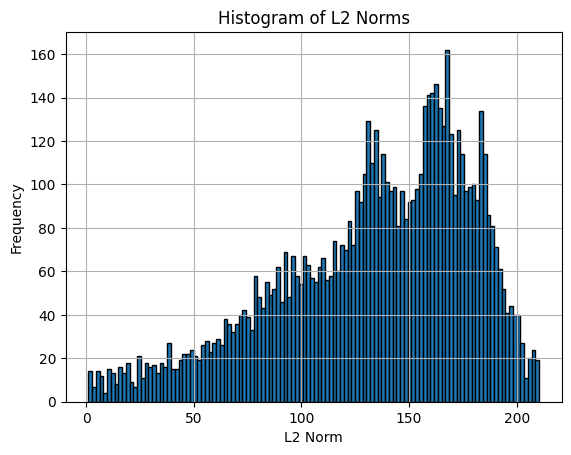

In [9]:
# Compute L2 norms for all slices
l2_norms = [np.linalg.norm(Y[k,...]) for k in range(Y.shape[0])]

# Plot histogram
plt.hist(l2_norms, bins=120, edgecolor='black')
plt.title('Histogram of L2 Norms')
plt.xlabel('L2 Norm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
margin = 100 ##!!
margin2 = 175 ##!!
keepindices = []
for k in range(Y.shape[0]):
    l2_norm = np.linalg.norm(Y[k,...])
    if l2_norm < margin or l2_norm > margin2:
        continue
    keepindices.append(k)
print(len(keepindices))

4151


In [11]:
X_l2filt = X[keepindices]
Y_l2filt = Y[keepindices]
X_l2filt.shape, Y_l2filt.shape

((4151, 256, 256, 1), (4151, 256, 256, 1))

In [ ]:
pwd

In [ ]:
break

## Train Test split

In [12]:
# from TTViterators import get_train_test_val_iterators
X, Y = X_l2filt, Y_l2filt
train_iterator, test_iterator, val_iterator = get_train_test_val_iterators(X,Y)
del X, Y, X_l2filt, Y_l2filt

True (3320, 256, 256, 1)
(3320, 256, 256, 1) (3320, 256, 256, 1) float32 float32 <class 'numpy.ndarray'> <class 'numpy.ndarray'> (831, 256, 256, 1) (831, 256, 256, 1) float32 float32 <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Train  True (2988, 256, 256, 1) True float32
Val    True (332, 256, 256, 1) True float32
Test.  True (831, 256, 256, 1) True float32


In [ ]:
break

# Load and compile model

In [13]:
from MEDCNN.models.G2DwithoutAttention import Gφψ, configs

In [14]:
mkdir traininglogs

In [15]:
cd traininglogs

/content/traininglogs


In [16]:
pwd

'/content/traininglogs'

In [17]:
ls -lart

total 8
drwxr-xr-x 1 root root 4096 Apr  4 18:42 ../
drwxr-xr-x 2 root root 4096 Apr  4 18:42 ./


In [ ]:
# from model import GφψIDWT, configs
# from modelAPS import Unet2DAPDS, configs
# from modelAPS import GφψAPS, configs

In [19]:
from MEDCNN.utils.dice import dice_coef
from MEDCNN.utils.compile1 import compile_model
from MEDCNN.utils.Train1 import train

In [20]:
CONFIGKEY= '4567'
CONFIGKEY= '3456'
CONFIGKEY= 'minimal2'
model, segconfig = Gφψ(config=configs[CONFIGKEY], compile=False), 'nonResidual'
# model, segconfig = Gφψ(config=configs[CONFIGKEY], compile=False), 'nonResidual'
model, lossname = compile_model(model, dataset, dice_coef)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwt2d (DWT2D)             │ (None, 128, 128, 4)    │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128, 128, 1)    │              0 │ dwt2d[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 2)    │             20 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 2)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 2)    │             38 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 2)    │              8 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 2)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwt2d_1 (DWT2D)           │ (None, 64, 64, 4)      │              0 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling (Pooling)         │ (None, 64, 64, 2)      │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 64, 64, 1)      │              0 │ dwt2d_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 3)      │              0 │ pooling[0][0],         │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 4)      │            112 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 4)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 4)      │            148 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 4)      │             16 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 4)      │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 31,335 (122.40 KB)

 Trainable params: 31,151 (121.68 KB)

 Non-trainable params: 184 (736.00 B)

In [ ]:
break

# Train one model

In [21]:
pwd

'/content/traininglogs'

In [22]:
ls -lart

total 2252
drwxr-xr-x 1 root root    4096 Apr  4 18:42 ../
-rw-r--r-- 1 root root 2297298 Apr  4 18:44 model.png
drwxr-xr-x 2 root root    4096 Apr  4 18:44 ./


In [23]:
dataset, lossname, segconfig, CONFIGKEY

('IBSR', 'bce', 'nonResidual', 'minimal2')

In [ ]:
break

2025-04-04 18:45:58.681632
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - IoU: 0.5381 - accuracy: 0.6995 - dice_coef: 0.6398 - loss: 0.5549
Epoch 1: val_loss improved from inf to 0.31711, saving model to 20250404G_IBSR_nonResidual_bce_configminimal2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - IoU: 0.5385 - accuracy: 0.6999 - dice_coef: 0.6403 - loss: 0.5542 - val_IoU: 0.8474 - val_accuracy: 0.9174 - val_dice_coef: 0.7915 - val_loss: 0.3171
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - IoU: 0.8910 - accuracy: 0.9424 - dice_coef: 0.8273 - loss: 0.2703
Epoch 2: val_loss improved from 0.31711 to 0.26128, saving model to 20250404G_IBSR_nonResidual_bce_configminimal2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - IoU: 0.8911 - accuracy: 0.9424 - dice_coef: 0.8274 - loss: 0.2702 - val_IoU: 0.8925 - val_accuracy: 0.9432 - val_dice_coef: 0.8477 - val_loss: 0.2613
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - IoU: 0.9154 - accuracy: 0.9558 - dice_coef: 0.8578 - loss: 0.2329
Epoch 3: val_loss

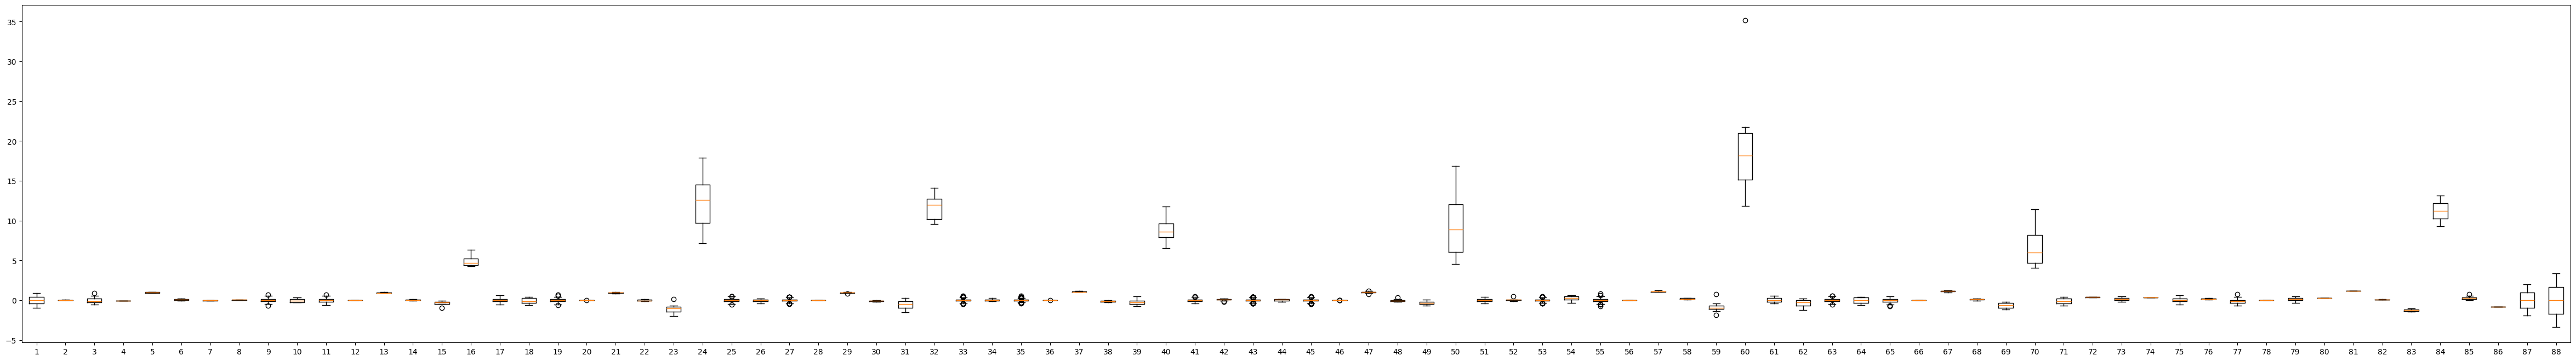

Elapsed time: mm:ss:mss 	 21:24:283


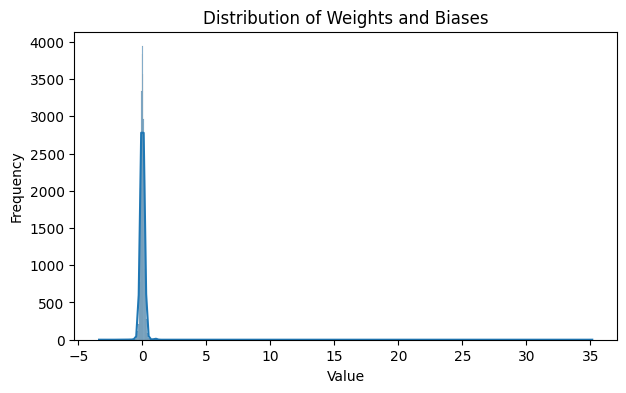

In [24]:
epochs = 40
train(model, train_iterator, test_iterator, val_iterator, dataset=dataset, segconfig=segconfig , lossname=lossname, CONFIGKEY=CONFIGKEY, epochs=epochs)


# Assuming `model` is your trained U-Net model
model_weights = model.get_weights()
all_weights = np.concatenate([w.flatten() for w in model_weights])
import seaborn as sns

# Plotting the histogram
plt.figure(figsize=(7, 4))
sns.histplot(all_weights, bins=900, kde=True)
plt.title('Distribution of Weights and Biases')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

  View model weights

In [25]:
model_weights = model.get_weights()
[_.shape for _ in model_weights]
[_.dtype for _ in model_weights]

[dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('floa

In [26]:
a = [_ for _ in model_weights if len(_.shape)>1 and _.shape[0]>1]
[_.shape for _ in a]

[(3, 3, 1, 2),
 (3, 3, 2, 2),
 (3, 3, 3, 4),
 (3, 3, 4, 4),
 (3, 3, 5, 8),
 (3, 3, 8, 8),
 (3, 3, 9, 16),
 (3, 3, 16, 16),
 (3, 3, 16, 32),
 (3, 3, 32, 32),
 (2, 2, 16, 32),
 (3, 3, 32, 16),
 (3, 3, 16, 16),
 (2, 2, 8, 16),
 (3, 3, 16, 8),
 (3, 3, 8, 8),
 (2, 2, 4, 8),
 (3, 3, 8, 4),
 (3, 3, 4, 4),
 (2, 2, 2, 4),
 (3, 3, 12, 1),
 (3, 3, 4, 2),
 (3, 3, 2, 2),
 (3, 3, 5, 1),
 (3, 3, 3, 1)]

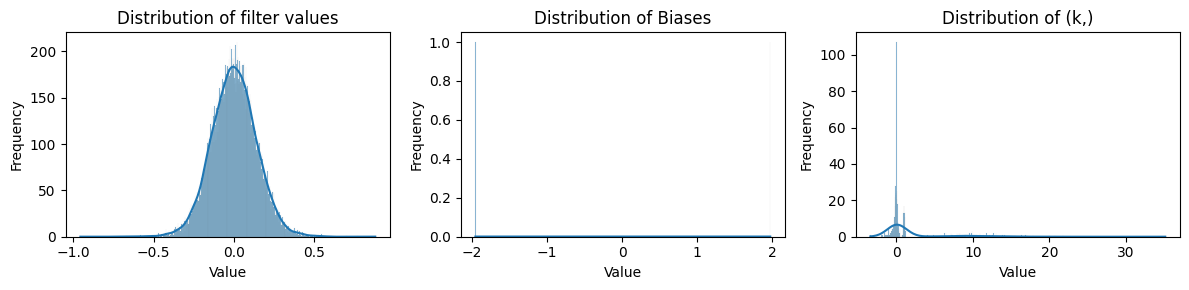

In [27]:
# Assuming `model` is your trained U-Net model
model_weights = model.get_weights()
# a = [_ for _ in model_weights if len(_.shape)>1]
a = [_ for _ in model_weights if len(_.shape)>1 and _.shape[0]>1]
b = [_ for _ in model_weights if len(_.shape)>1 and _.shape[0]==1]
c = [_ for _ in model_weights if len(_.shape)==1]
c
# all_weights = np.concatenate([w.flatten() for w in model_weights])
# all_weights.shape


# Assuming `model` is your trained U-Net model
# model_weights = model.get_weights()
# all_weights = np.concatenate([w.flatten() for w in model_weights])
all_filter_vals = np.concatenate([w.flatten() for w in a])
all_bias1 = np.concatenate([w.flatten() for w in b])
all_bias2 = np.concatenate([w.flatten() for w in c])
import seaborn as sns

# Plotting the histogram
plt.figure(figsize=(12, 3))
plt.subplot(131)
sns.histplot(all_filter_vals, bins=900, kde=True)
plt.title('Distribution of filter values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(132)
sns.histplot(all_bias1, bins=900, kde=True)
plt.title('Distribution of Biases')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(133)
sns.histplot(all_bias2, bins=900, kde=True)
plt.title('Distribution of (k,)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [28]:
model_weights[2].shape

(3, 3, 2, 2)

In [29]:
model.weights[0][:,:,0,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.27372727,  0.26209396,  0.87732214],
       [-0.9543436 ,  0.5849458 , -0.42289048],
       [ 0.482358  , -0.62728983, -0.24110852]], dtype=float32)>

In [30]:
a[6].shape

(3, 3, 9, 16)

In [31]:
import math

def next_perfect_square(n):
    root = math.ceil(math.sqrt(n))
    return root ** 2

# Given number
# n = 65

# Find the next perfect square
# next_square = next_perfect_square(n)
# next_square

In [32]:
[_.shape for _ in a]

[(3, 3, 1, 2),
 (3, 3, 2, 2),
 (3, 3, 3, 4),
 (3, 3, 4, 4),
 (3, 3, 5, 8),
 (3, 3, 8, 8),
 (3, 3, 9, 16),
 (3, 3, 16, 16),
 (3, 3, 16, 32),
 (3, 3, 32, 32),
 (2, 2, 16, 32),
 (3, 3, 32, 16),
 (3, 3, 16, 16),
 (2, 2, 8, 16),
 (3, 3, 16, 8),
 (3, 3, 8, 8),
 (2, 2, 4, 8),
 (3, 3, 8, 4),
 (3, 3, 4, 4),
 (2, 2, 2, 4),
 (3, 3, 12, 1),
 (3, 3, 4, 2),
 (3, 3, 2, 2),
 (3, 3, 5, 1),
 (3, 3, 3, 1)]

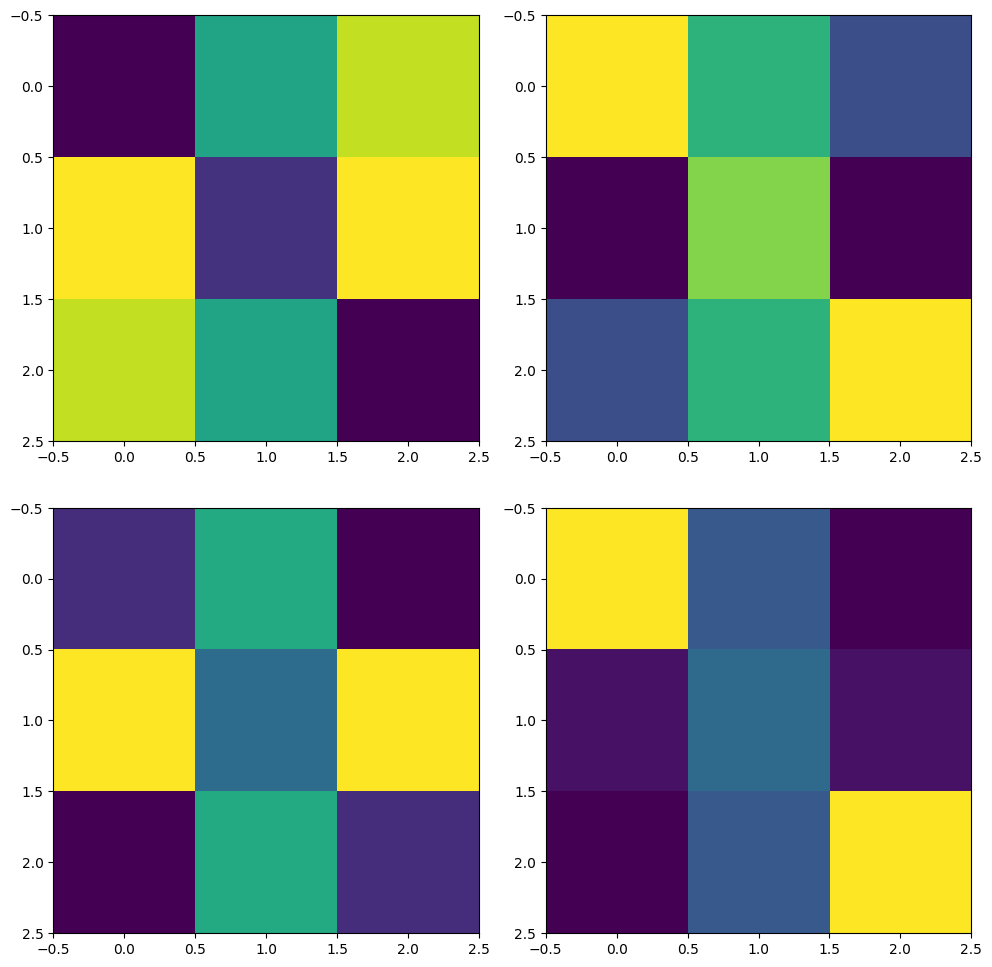

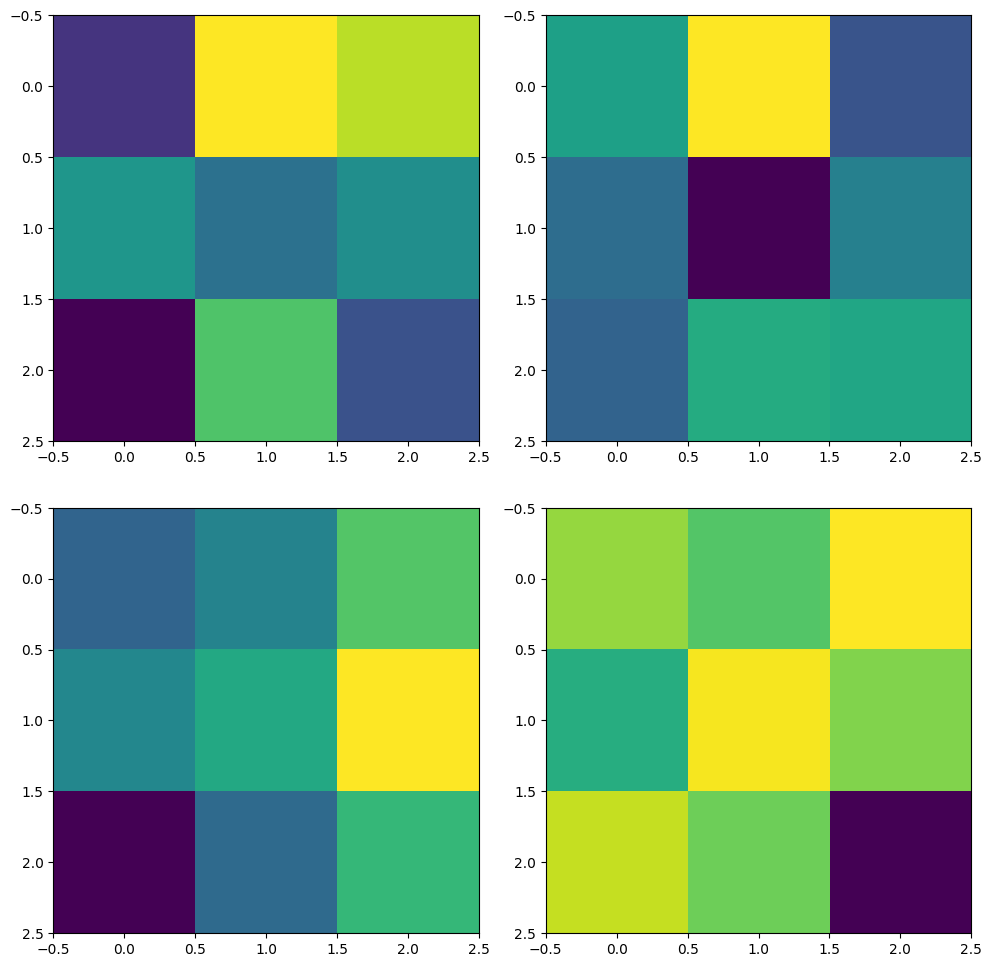

In [33]:
#MEDCNN plot
idx = 2
ch = 2
_ = a[idx]
grid = int(np.sqrt(next_perfect_square(_.shape[-1])))
plt.figure(figsize=(10,10))
for i in range(_.shape[-1]):
    plt.subplot(grid,grid,i+1)
    # plt.imshow(tf.abs(model.weights[0][:,:,0,i]))
    # plt.imshow(_[:,:,ch,i])#.astype(np.float32))
    plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(_[:,:,ch,i]))))#.astype(np.float32))
    # plt.imshow(np.angle(np.fft.fft2(_[:,:,1,i])))#.astype(np.float32))
plt.tight_layout()


grid = int(np.sqrt(next_perfect_square(_.shape[-1])))
plt.figure(figsize=(10,10))
for i in range(_.shape[-1]):
    plt.subplot(grid,grid,i+1)
    # plt.imshow(tf.abs(model.weights[0][:,:,0,i]))
    plt.imshow(_[:,:,ch,i])#.astype(np.float32))
    # plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(_[:,:,ch,i]))))#.astype(np.float32))
    # plt.imshow(np.angle(np.fft.fft2(_[:,:,1,i])))#.astype(np.float32))
plt.tight_layout()

# Segment and view test MR slices

    Segment and view the test slices

In [34]:
X_batch, Y_batch = test_iterator.__getitem__(0)
X_batch.shape, Y_batch.shape

((20, 256, 256, 1), (20, 256, 256, 2))

In [35]:
yhat = model.predict(X_batch)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(20, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(20, 256, 256, 1) (20, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(20, 256, 256, 2) <<
(20, 256, 256) <<


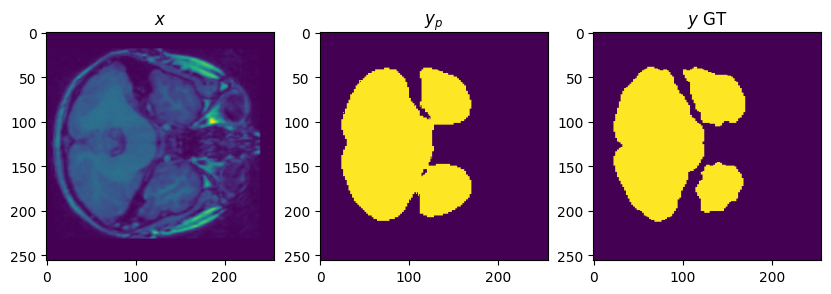

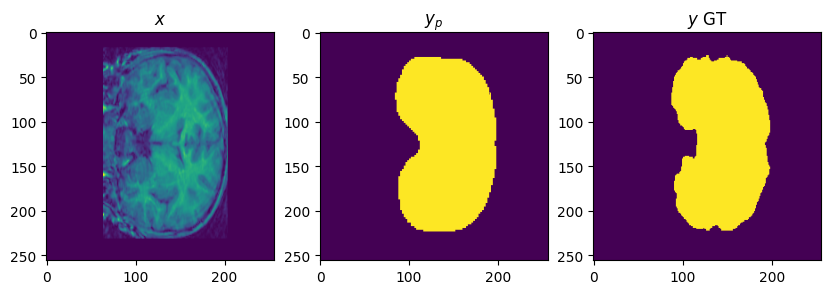

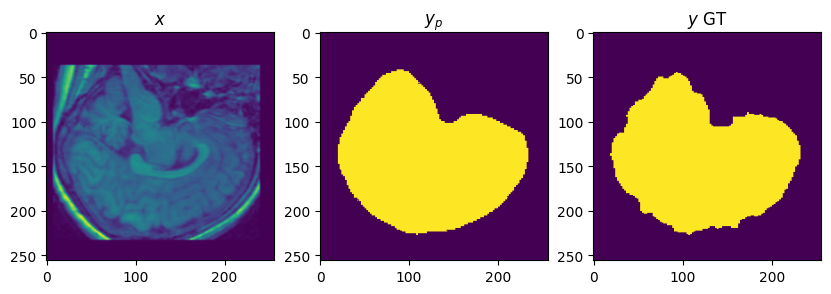

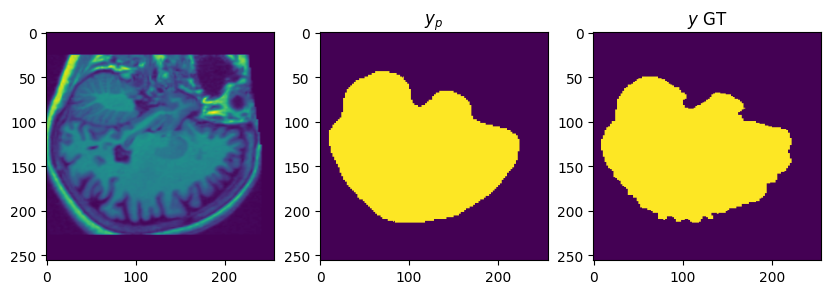

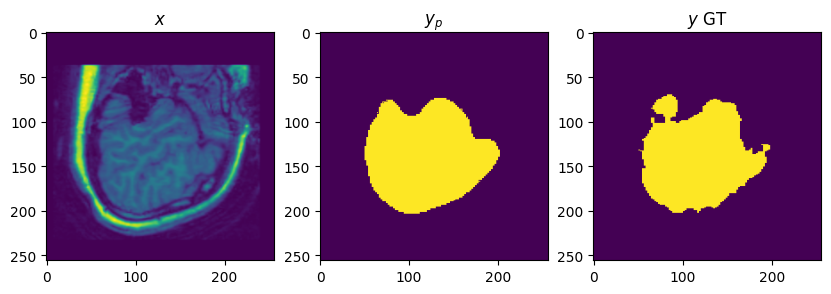

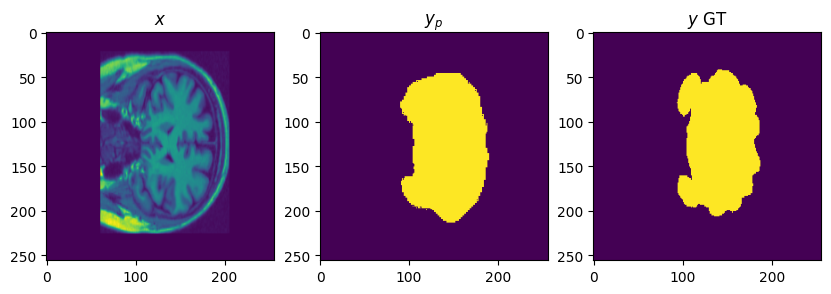

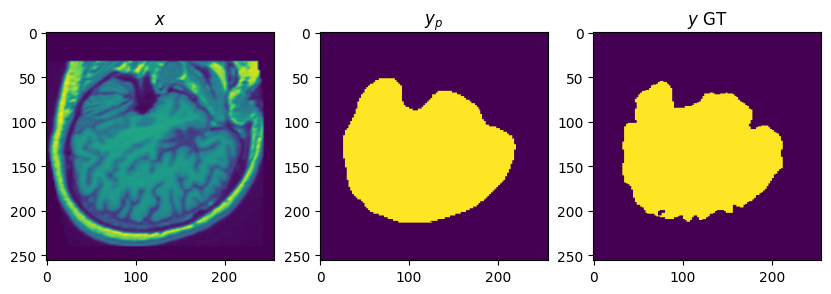

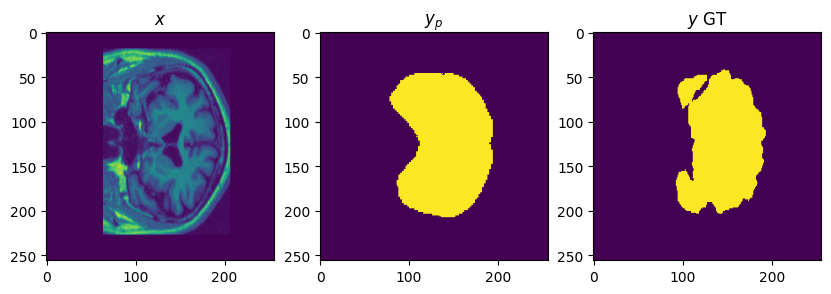

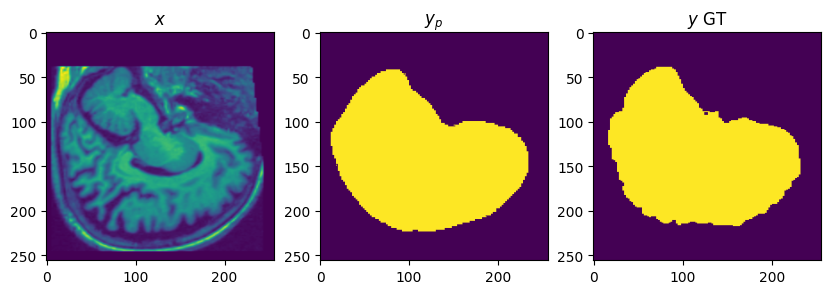

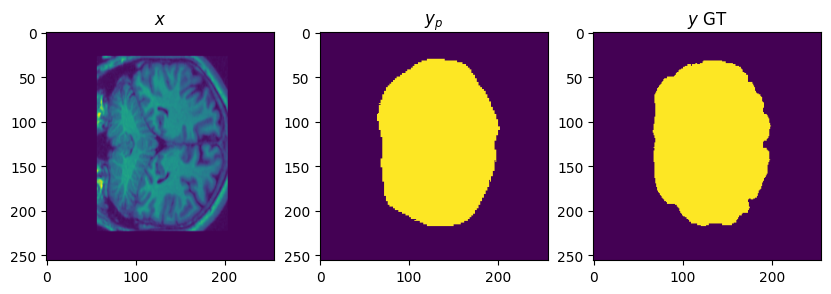

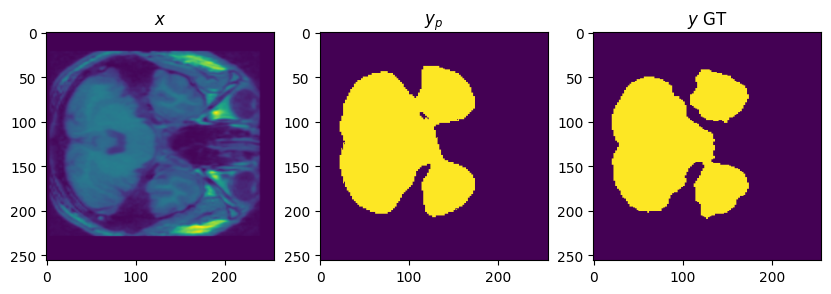

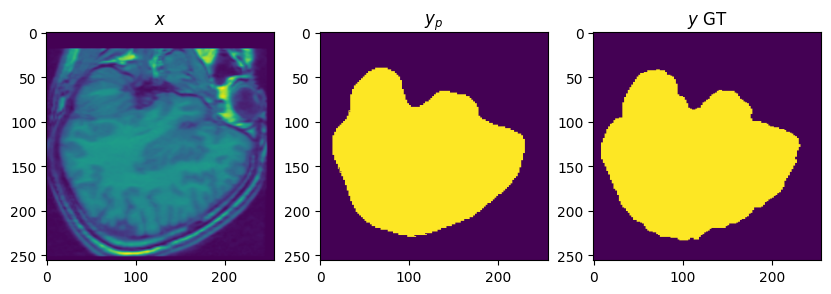

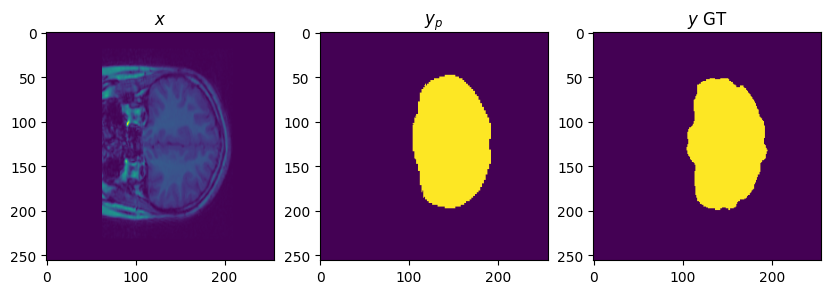

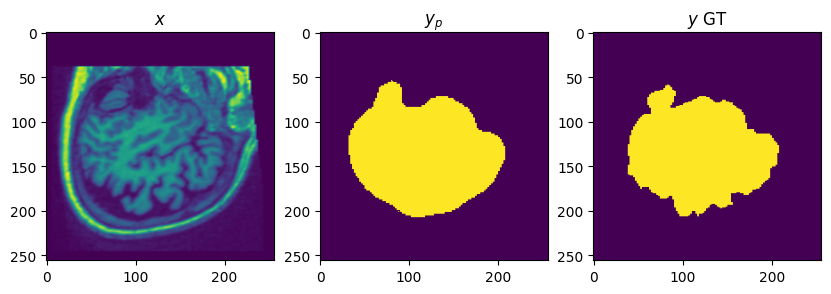

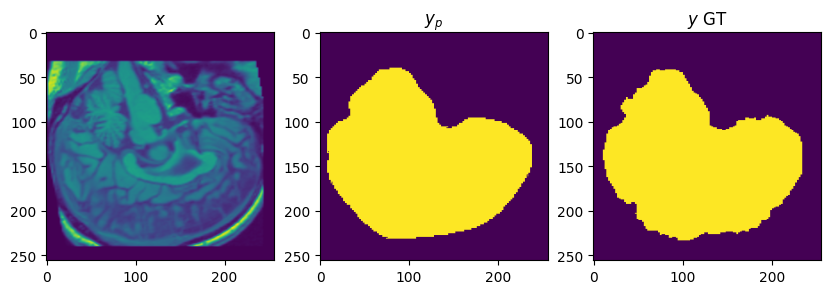

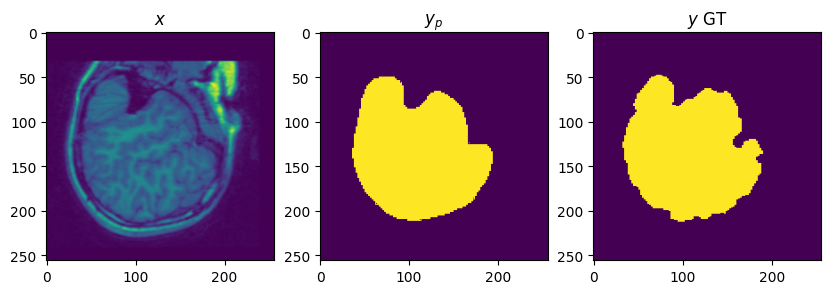

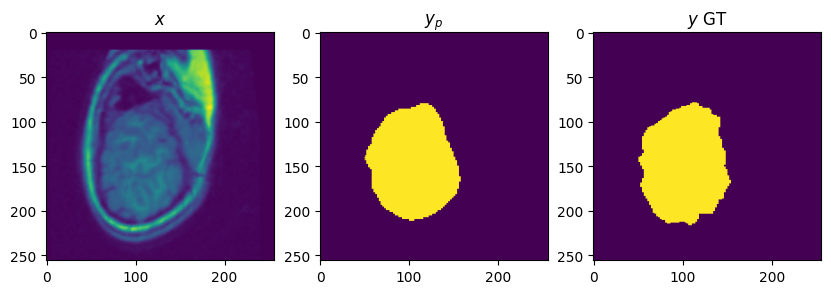

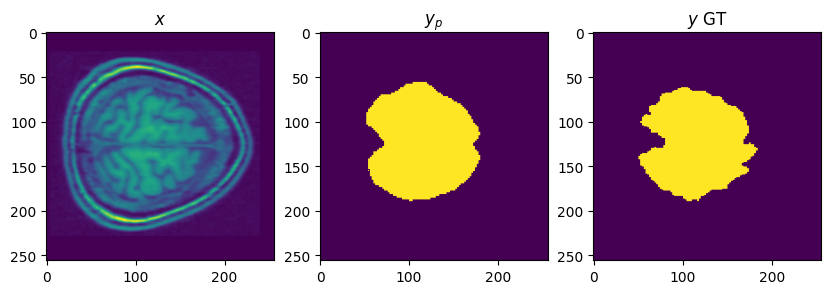

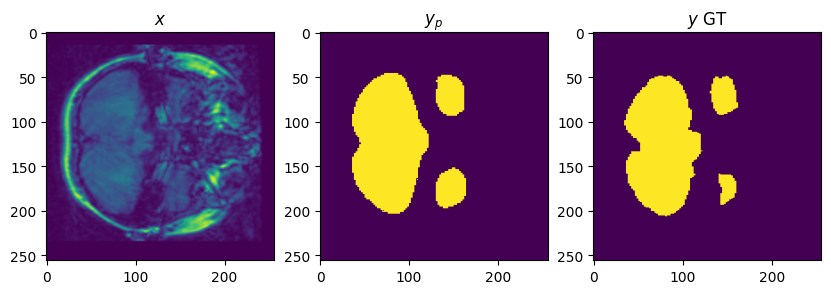

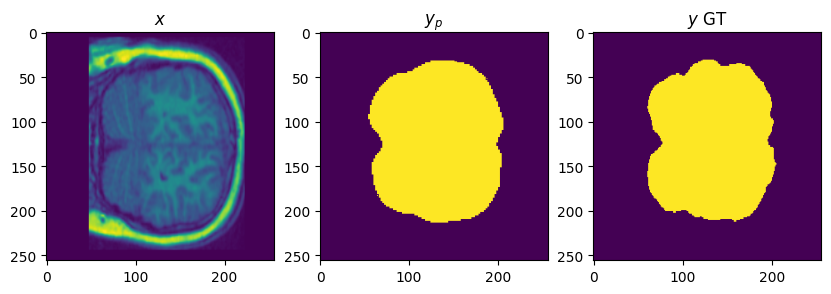

In [36]:
count=0
for batch in test_iterator:
    a, b = batch
    b = np.argmax(b, axis=-1)
    print(a.shape, b.shape)
    yhat = model.predict(a)
    print(yhat.shape,'<<')
    yhat = np.argmax(yhat, axis=-1)
    print(yhat.shape,'<<')


    for k in range(a.shape[0]):
        plt.figure(figsize=(10,3))
        plt.subplot(131), plt.imshow(a[k,:,:,:]), plt.title('$x$')
        plt.subplot(132), plt.imshow(yhat[k,:,:,]), plt.title('$y_p$')
        plt.subplot(133), plt.imshow(b[k,:,:]), plt.title('$y$ GT')
        plt.show()

    count+=1
    if count == 1:
        break